<a href="https://colab.research.google.com/github/pouyarb/Algorithm/blob/main/optimization_problems/BlackLitterman_rev02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install yahoofinancials
!pip install PyPortfolioOpt

In [69]:
import pandas as pd
import numpy as np

from pypfopt import black_litterman, expected_returns, BlackLittermanModel, EfficientFrontier

import yfinance as yf
from yahoofinancials import YahooFinancials
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
# import torch
# from torch import nn

# load data

In [4]:
# list from https://www.cnbc.com/dow-30/
Dow_list = [  'AXP', 'AMGN', 'AAPL','BA','CAT','CSCO', 'CVX',
              'GS', 'HD', 'HON', 'IBM','INTC','JNJ', 'KO', 'JPM',
              'MCD','MMM', 'MRK','MSFT','NKE','PG','TRV','UNH', 'CRM',
              'VZ','V', 'WBA', 'WMT','DIS', 'DOW']
print(len(Dow_list))

30


In [5]:
yf_close_df = yf.download(Dow_list, start='2021-01-01',end='2023-09-30')['Close']

[*********************100%%**********************]  30 of 30 completed


In [6]:
market_prices = yf.download("SPY", start='2021-01-01',end='2023-09-30')["Close"]

[*********************100%%**********************]  1 of 1 completed


In [ ]:
yf_close_df

In [7]:
from sklearn.model_selection import train_test_split

total_rows = len(yf_close_df)
train_size = int(0.8 * total_rows)

# Split the DataFrame into training and testing sets
yf_train_df = yf_close_df.iloc[:train_size]
yf_test_df = yf_close_df.iloc[train_size:]

In [ ]:
yf_train_df

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,129.410004,226.660004,118.040001,202.720001,182.149994,220.309998,43.959999,84.709999,177.679993,54.040001,...,77.251907,217.690002,140.100006,137.820007,135.649994,349.500000,217.759995,58.849998,41.400002,146.529999
2021-01-05,131.009995,227.759995,118.669998,211.630005,183.639999,221.520004,43.980000,87.000000,178.440002,55.799999,...,77.385498,217.899994,141.229996,138.699997,134.529999,344.799988,214.509995,58.580002,41.160000,145.750000
2021-01-06,126.599998,233.250000,123.059998,211.029999,193.860001,216.149994,44.400002,89.800003,179.119995,58.430000,...,78.606873,212.250000,142.350006,140.160004,139.100006,359.269989,212.619995,59.290001,43.029999,146.660004
2021-01-07,130.919998,234.020004,121.660004,212.710007,194.229996,217.979996,44.959999,90.220001,178.580002,58.509998,...,80.171753,218.289993,144.949997,138.850006,139.070007,365.029999,213.809998,58.529999,45.259998,146.649994
2021-01-08,132.050003,238.490005,121.779999,209.899994,194.259995,222.039993,45.060001,91.080002,178.690002,58.209999,...,79.227097,219.619995,146.350006,138.789993,139.649994,363.390015,215.449997,57.799999,45.209999,146.630005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-08,152.869995,228.429993,174.830002,207.199997,248.720001,182.949997,49.110001,162.990005,99.300003,56.259998,...,108.279999,253.699997,119.860001,137.580002,177.770004,470.600006,222.190002,37.529999,34.480000,138.100006
2023-03-09,150.589996,225.789993,172.119995,201.240005,240.960007,178.720001,48.810001,160.509995,96.139999,55.099998,...,107.599998,252.320007,117.870003,136.570007,173.919998,464.910004,220.009995,36.549999,33.290001,137.169998
2023-03-10,148.500000,227.869995,165.699997,203.070007,227.009995,173.179993,48.560001,159.669998,93.570000,53.880001,...,107.690002,248.589996,117.489998,137.190002,175.679993,460.329987,216.139999,36.680000,33.259998,136.970001


In [ ]:
correlation_matrix = yf_close_df.corr()

# Set the size of the plot
plt.figure(figsize=(16, 10))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)

# Set plot labels and title
plt.title("Correlation Matrix")
plt.show()

In [20]:
def plot_weights(w):
  global yf_close_df
  x_labels = yf_close_df.columns

  # Create a plot
  plt.figure(figsize=(12, 6))
  plt.plot(w)

  # Set the X-axis labels using the column names
  plt.xticks(range(len(x_labels)), x_labels, rotation=45)

  # Add labels and a title
  plt.xlabel('Assets')
  plt.ylabel('w')
  plt.title('Portfolio Weights')

  # Show the plot
  plt.show()

In [63]:
viewdict = {}
for s in Dow_list: viewdict[s] = np.random.normal(0.2, 0.2)
viewdict

{'AXP': 0.04026100989550643,
 'AMGN': 0.2566565280816095,
 'AAPL': 0.1128751727951057,
 'BA': 0.13609613273623586,
 'CAT': 0.4306706636876491,
 'CSCO': -0.10855555298582087,
 'CVX': 0.3358593346397484,
 'GS': 0.31235980461123597,
 'HD': 0.504899757853273,
 'HON': 0.03804766417143679,
 'IBM': 0.2922457400523474,
 'INTC': 0.0363736479139431,
 'JNJ': 0.19855516512308774,
 'KO': 0.29231713924169994,
 'JPM': 0.21227750022084507,
 'MCD': 0.2716908398645802,
 'MMM': 0.23797447432300756,
 'MRK': 0.17030169953066554,
 'MSFT': 0.3803021905818568,
 'NKE': 0.059074951325235325,
 'PG': 0.014819065349638005,
 'TRV': 0.04114152528005713,
 'UNH': 0.37178966426250565,
 'CRM': 0.2760905869798778,
 'VZ': -0.02756128556498344,
 'V': -0.11014610201126701,
 'WBA': -0.10172599765024382,
 'WMT': 0.7323485387893383,
 'DIS': 0.15371798772093415,
 'DOW': 0.1507012616904322}

In [71]:
Sigma = yf_train_df.cov()
mu_capm = expected_returns.capm_return(yf_train_df)

delta = black_litterman.market_implied_risk_aversion(market_prices)
market_prior = black_litterman.market_implied_prior_returns(mu_capm, delta, Sigma)

bl = BlackLittermanModel(Sigma, pi=market_prior, absolute_views=viewdict)
mu_bl = bl.bl_returns()
Sigma_bl = bl.bl_cov()

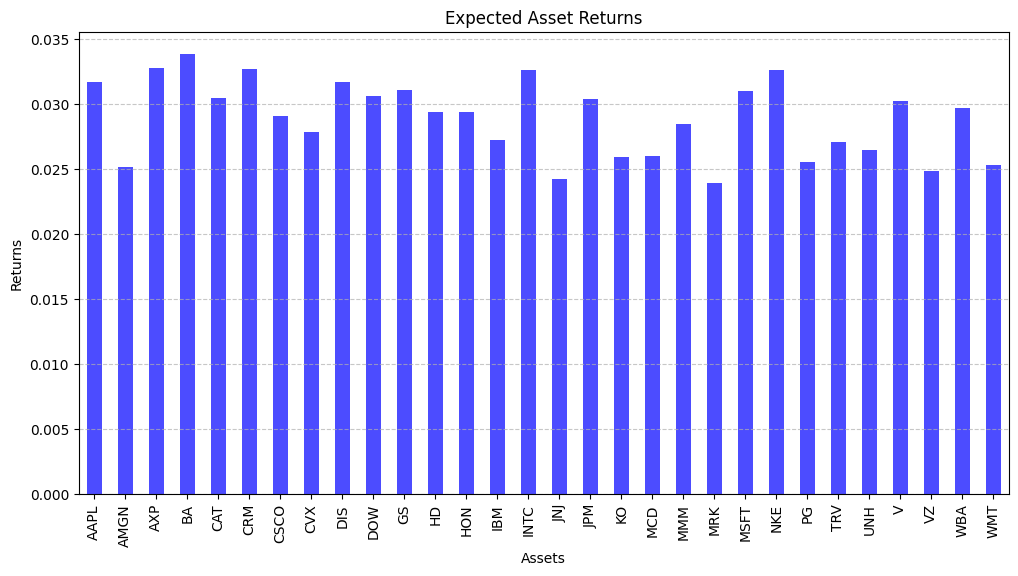

In [19]:
# returns = yf_train_df.pct_change()
# mu = returns.mean()

plt.figure(figsize=(12, 6))
mu_capm.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Expected Asset Returns')
plt.xlabel('Assets')
plt.ylabel('Returns')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# optimization

\begin{align*}
\text{minimize} \quad & f(w) = w^T \Sigma w \\
\text{subject to} \quad &
\begin{aligned}
&\sum_{i=1}^{n} w_i = 1 \quad \text{(Budget Constraint)} \\
&w_i \geq 0, \quad i = 1, \ldots, n \quad \text{(Non-negativity Constraint)} \\
&w^T \mu \geq \mu_{\text{min}} \quad \text{(Mean Constraint)}
\end{aligned}
\end{align*}

\begin{align*}
\text{minimize} \quad & f(w) = w^T \Sigma w - \lambda w^T \mu\\
\text{subject to} \quad &
\begin{aligned}
&\sum_{i=1}^{n} w_i = 1 \quad \text{(Budget Constraint)} \\
&w_i \geq 0, \quad i = 1, \ldots, n \quad \text{(Non-negativity Constraint)}
\end{aligned}
\end{align*}

$\lambda$ is a hyperparameter.

In [78]:
from scipy.optimize import minimize

def black_litterman_sci(mu):
    n = len(mu)  # Number of assets

    def objective(w):
        return -1 * w.dot(mu)

    # Constraints
    constraints = [
        {"type": "eq", "fun": lambda w: w.sum() - 1}  # Budget constraint
    ]

    bounds = [(0, 1) for _ in range(n)]  # Non-negativity constraint

    w0 = [1/n] * n  # Initial guess for weights

    options={
        'disp': True
        # ,'iprint':2
        }

    result = minimize(objective, w0, bounds=bounds, constraints=constraints, method='SLSQP', options=options)

    return result

Optimization terminated successfully    (Exit mode 0)
            Current function value: -55.28870673115155
            Iterations: 2
            Function evaluations: 62
            Gradient evaluations: 2


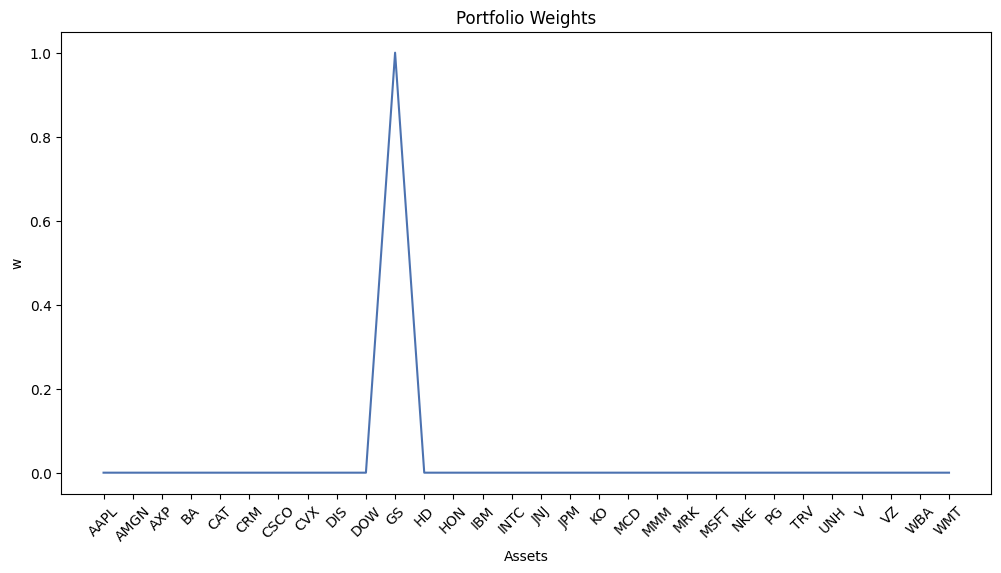

In [79]:
optim_result = black_litterman_sci(mu_bl)
w = optim_result.x
plot_weights(w)

In [88]:
import cvxpy as cp

def black_litterman_cvx(mu):
    n = len(mu)  # Number of assets

    w = cp.Variable(n)
    objective = -1 * w @ mu

    # Constraints
    constraints = [
        lambda w: cp.sum(w) == 1,  # Budget constraint
        lambda w: w >= 0,
        lambda w: w <= 1
    ]

    opt = cp.Problem(cp.Minimize(objective), [f(w) for f in constraints])
    opt.solve(verbose=True)

    return opt, w

In [89]:
optim_result, w = black_litterman_cvx(mu_bl)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Nov 10 10:17:34 AM: Your problem has 30 variables, 3 constraints, and 0 parameters.
(CVXPY) Nov 10 10:17:34 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 10 10:17:34 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 10 10:17:34 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 10 10:17:34 AM: Compiling problem (target solver=ECOS).
(CVXPY) Nov 10 10:17:34 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

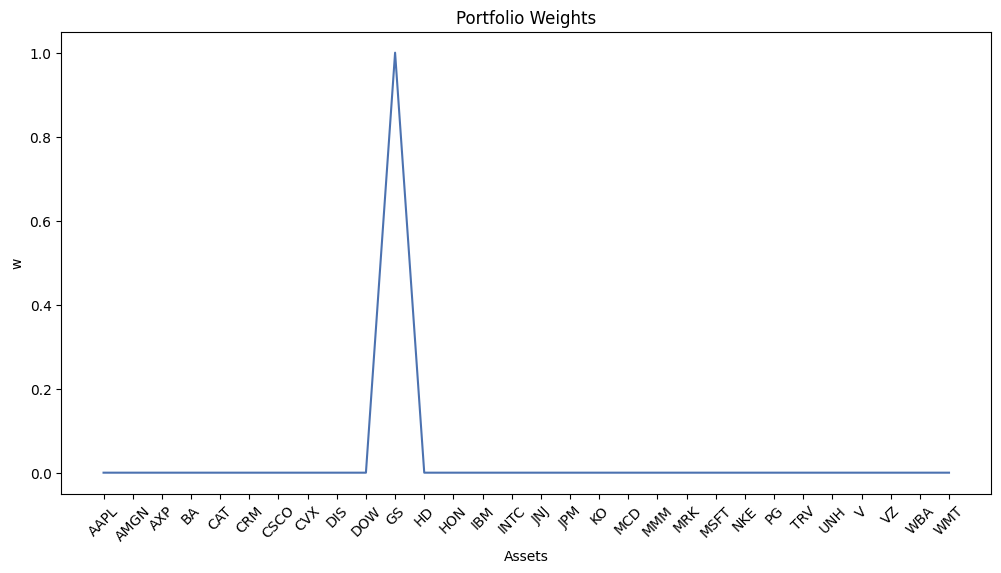

In [90]:
plot_weights(w.value)

# pypfopt optimization

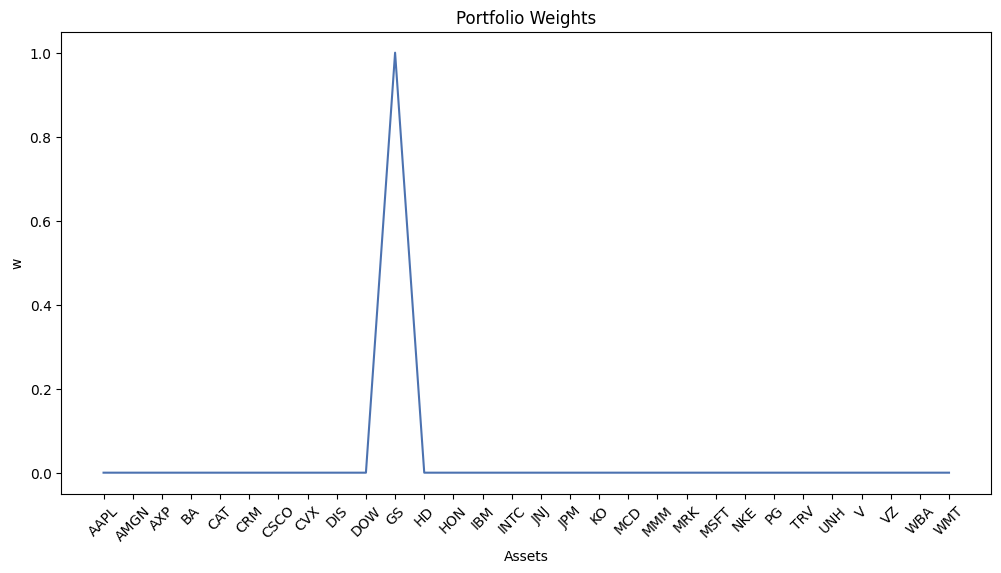

In [91]:
ef = EfficientFrontier(mu_bl, Sigma)
ef._max_return()

weights = ef.clean_weights()
plot_weights(weights.values())

# performance

In [92]:
def performance(w, mu, dist, Sigma, risk_free_rate=0):

  volatility = np.sqrt(w.dot(Sigma).dot(w))
  expected_return = w.dot(mu)
  return_a = w.dot(dist)
  sharpe = (expected_return - risk_free_rate) / volatility

  print("Expected annual return: {:.1f}%".format(100 * expected_return))
  print("annual return for 138 day: {:.1f}%".format(100 * return_a))
  print("Annual volatility: {:.1f}%".format(100 * volatility))
  print("Sharpe Ratio: {:.2f}".format(sharpe))

  return expected_return, volatility, sharpe

In [93]:
w = np.array(list(weights.values()))

returns_test = yf_test_df.pct_change()
mu_test = returns.mean()
dist = (yf_test_df.iloc[-1] / yf_test_df.iloc[0]) - 1
Sigma_test = yf_test_df.cov()

performance(w, mu_test, dist, Sigma_test)

Expected annual return: 0.1%
annual return for 138 day: 3.6%
Annual volatility: 1174.3%
Sharpe Ratio: 0.00


(0.0005062257957904907, 11.743480808330904, 4.310696326351304e-05)